In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Input
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Path to chess piece images
dataset_path = '/content/drive/MyDrive/Colab Notebooks/fruits/fruits-360_original-size/fruits-360-original-size/Validation'
img_size = (224, 224)
batch_size = 32
seed = 42

In [4]:
# Load full dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=seed,
    shuffle=True  # Shuffle before splitting
)

Found 2931 files belonging to 21 classes.


In [5]:
# Split manually: 80% train, 20% test
dataset_size = len(full_ds)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)

In [6]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
])

In [7]:
# Apply augmentation
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

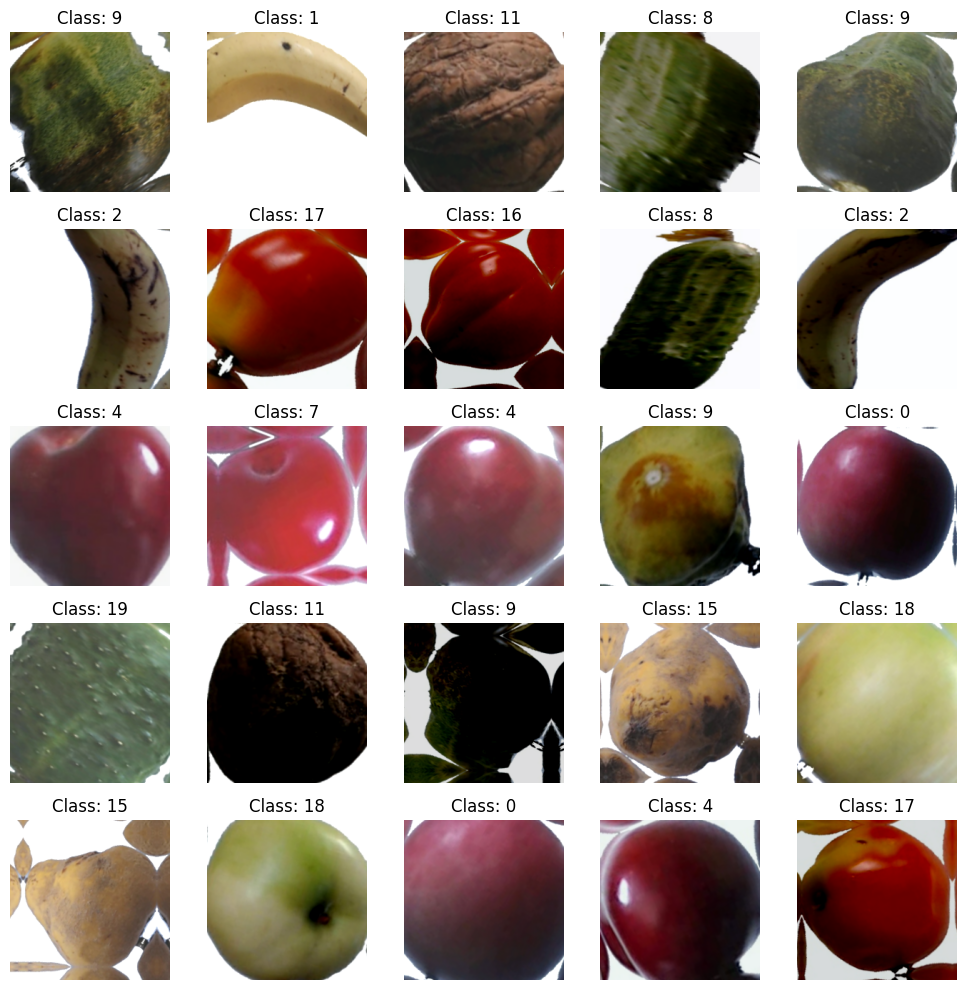

In [8]:
# Show Images

import matplotlib.pyplot as plt

# Take a single batch of images from the augmented training dataset
image_batch, label_batch = next(iter(augmented_train_ds))

# Number of images to display (25 in a 5x5 grid)
num_images_to_display = 25

# Create a 5x5 grid for the images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Iterate over the images in the batch
for i in range(num_images_to_display):
  ax = axes[i // 5, i % 5]  # Get the current subplot
  ax.imshow(image_batch[i].numpy().astype("uint8"))  # Display the image
  ax.set_title(f"Class: {label_batch[i].numpy()}")  # Set the class label as the title
  ax.axis("off")  # Turn off axes

plt.tight_layout()
plt.show()

In [9]:
# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [10]:
# Build Custom CNN model
model = Sequential([
    Input(shape=(img_size[0], img_size[1], 3), name='input_layer'),
    Rescaling(1./255),
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2,2)),
    MaxPooling2D((3,3)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(full_ds.class_names), activation='softmax')
])

# Compile
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 21)             │         5,397 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,293 (1.74 MB)

 Trainable params: 456,293 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train
history = model.fit(augmented_train_ds, epochs=10)

Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.2000 - loss: 2.6630
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 186s 3s/step - accuracy: 0.6116 - loss: 1.1129
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.6849 - loss: 0.8024
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.7515 - loss: 0.5894
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.7742 - loss: 0.5273
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.8327 - loss: 0.4102
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.8206 - loss: 0.4175
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.8297 - loss: 0.4218
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.8339 - loss: 0.4151
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.8320 - loss: 0.4148


In [13]:
# Transfer Learning

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load pre-trained VGG16 model (excluding top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(full_ds.class_names), activation='softmax')
])


# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Note: You would typically split and preprocess your dataset (train_ds, test_ds, augmented_train_ds)
# before training. For this self-contained cell, we are directly using full_ds for demonstration,
# but for proper training and evaluation, you should use separate train and test datasets.
# If you want to use the previously defined augmented_train_ds and test_ds,
# make sure the cells defining them are executed before this cell.

# Train the model
# history = model.fit(augmented_train_ds, epochs=10) # Use augmented_train_ds for training
# Evaluate the model
# test_loss, test_acc = model.evaluate(test_ds) # Use test_ds for evaluation

# As an alternative for this self-contained cell (not recommended for proper workflow):
# You can train and evaluate on full_ds, but this will not give a realistic performance estimate.
# history = model.fit(full_ds, epochs=10)
# test_loss, test_acc = model.evaluate(full_ds)


# Plot accuracy
# plt.plot(history.history['accuracy'], label='Train Acc')
# plt.plot(history.history['val_accuracy'], label='Val Acc') # val_accuracy requires validation_data in model.fit
# plt.legend()
# plt.show()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 21)             │         5,397 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,142,869 (80.65 MB)

 Trainable params: 6,428,181 (24.52 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:


# Train the model
history = model.fit(augmented_train_ds, epochs=10)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")




Epoch 1/10


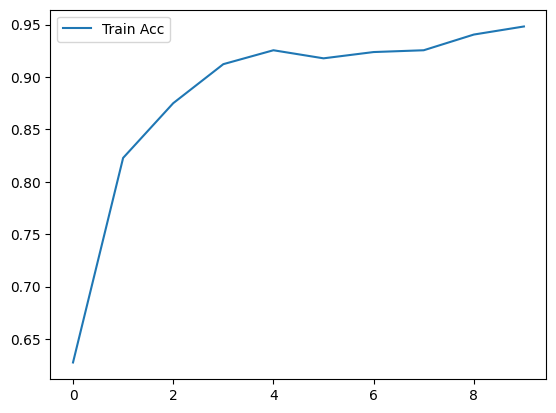

In [16]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
# plt.plot(history.history['val_accuracy'], label='Val Acc') # val_accuracy requires validation_data in model.fit
plt.legend()
plt.show()